# Analyse prediction scores & calculate 95%CI

over all bootstrapping iterations 

- metrics assessed:
    - accuracy
    - precision
    - recall
    - f1
    - brier
    - roc-auc
    - precision-recall

In [1]:
PATH = "/home/WUR/katz001/PROJECTS/myaReg-genderDifferences"

import os
import numpy as np
import json
import pandas as pd
import sys 
import errno  
import seaborn as sns
sys.path.append(f"{PATH}/scripts")

import matplotlib.pyplot as plt 
import pickle

from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score, f1_score, brier_score_loss, roc_auc_score, average_precision_score

In [9]:
### Read dataset and split
''' 
Prepare data --> change here for different setups!
'''
target = "gender"
n_iter = 300


dataset = "natural"
percentBoruta = 100
varFolder = "boruta"
vars = f"{target}_bootstrapped_iterativeBoruta_{percentBoruta}perc"

''' 
Select features
'''

varPath = f"{PATH}/results/20_featureSelection/{dataset}/{varFolder}/{vars}.txt"
sel_variables = pd.read_csv(varPath, header=None)[0].tolist()


''' 
Define paths
'''
folderFigures = f"{PATH}/figures/40_externalValidation/{dataset}/{vars}"
resultsPath = f"{PATH}/results/40_externalValidation/{dataset}"


dataPath = f"{PATH}/data/validation/"
modelPath = f"{PATH}/results/30_internalValidation/{dataset}/{vars}"

''' 
Variables
'''
with open(f"{PATH}/data/validation/discovery_validation_variables_translation.json", "r") as f: varTranslation = json.load(f)
dutch_varTranslation = {v: k for k, v in varTranslation.items()}

''' 
Read validation data
'''
with open(f"{PATH}/data/validation/validation_dtypes.json", "r") as f:
    dtypes = json.load(f)

data = pd.read_csv(f"{dataPath}/dutch_MG_patients_V2_recoded.csv", index_col=0, dtype=dtypes)
tmp = data.select_dtypes(include=["float32"]).columns 
data[tmp] = data[tmp].astype(pd.Int64Dtype())


''' Only parse variables needed for model '''
variables = pd.read_csv(f"{PATH}/results/20_featureSelection/{dataset}/{varFolder}/{vars}.txt", 
                       header=None)[0].tolist()
variables.append("gender")
variables_dutch = [varTranslation[ele] for ele in variables]
data = data.loc[:,variables_dutch]

''' translate varnames to German registry to fit models! '''
data.columns = [dutch_varTranslation[ele] for ele in data.columns]


''' 
Split
'''
X_val = data.drop(target, axis=1)
y_val = data[target]

In [10]:
''' Load predProba'''
model = 'rfc'
with open(f'{resultsPath}/bootstrap_validation_n{n_iter}_predProba.pickle', 'rb') as f:
    dic_proba = pickle.load(f)
data = pd.DataFrame.from_dict(dic_proba, orient="index").sort_index().T

In [11]:
dic_performanceScores = {
    "acc":np.array([]),
    "prec":np.array([]),
    "recall":np.array([]),
    "f1-score":np.array([]),
    "brier":np.array([]),
    "roc_auc":np.array([]),
    "pr":np.array([]),
}
for run in range(data.shape[1]):
    predproba = data[run][data[run].notna()]
    pred = predproba.copy()
    pred[predproba < 0.5] = 0
    pred[predproba >= 0.5] = 1
    tru = y_val.loc[predproba.index]   
    
    ## Accuracy
    dic_performanceScores["acc"] = np.append(dic_performanceScores["acc"],balanced_accuracy_score(tru, pred))
    ## Precision
    dic_performanceScores["prec"] = np.append(dic_performanceScores["prec"],precision_score(tru, pred))
    ## Recall
    dic_performanceScores["recall"] = np.append(dic_performanceScores["recall"],recall_score(tru, pred))
    # F1-score
    dic_performanceScores["f1-score"] = np.append(dic_performanceScores["f1-score"],f1_score(tru, pred))
    ## Brier
    dic_performanceScores["brier"] = np.append(dic_performanceScores["brier"],brier_score_loss(tru, predproba))
    ## ROC AUC
    dic_performanceScores["roc_auc"] = np.append(dic_performanceScores["roc_auc"],roc_auc_score(tru, predproba))
    ## PR
    dic_performanceScores["pr"] = np.append(dic_performanceScores["pr"],average_precision_score(tru, predproba))

df_scores = pd.DataFrame.from_dict(dic_performanceScores)

""" 
Save
"""
df_scores.to_csv(f"{resultsPath}/summary_scores.csv")



# Calculate CI

In [12]:
""" 
Calculate confidence intervals 
"""
df_ci = pd.DataFrame()
for col in df_scores.columns:
    df_ci[col] = np.array([np.mean(df_scores[col]),np.percentile(df_scores[col], 2.5), np.percentile(df_scores[col], 97.5)])
df_ci.index = ["mean", "lower_CI", "upper_CI"]

#### Save to file
df_ci.to_csv(f"{resultsPath}/bootstrap_CI_95%.csv")

<AxesSubplot:>

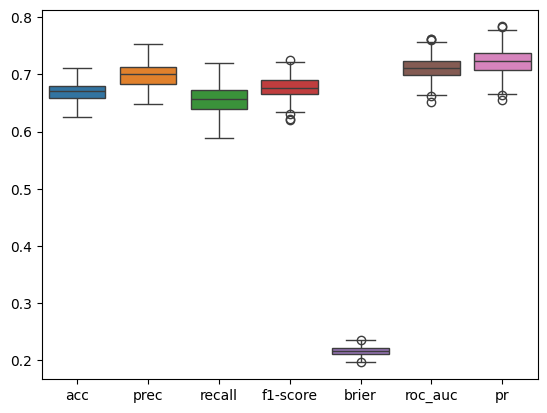

In [13]:
fig, ax = plt.subplots()
df_tmp = df_scores.copy()
sns.boxplot(data=df_tmp)
#ax.set_ylim(0.5, 1)

In [14]:
print("\n\n\n",dataset, "\n\n\n")
for i, col in enumerate(df_ci.columns):
    print(col)
    print("%.3f" % df_ci.iloc[0, i], "(95%CI", "%.3f," % df_ci.iloc[1, i], "%.3f)" % df_ci.iloc[2, i])
    print("%.3f" % df_ci.iloc[0, i], "(%.3f," % df_ci.iloc[1, i], "%.3f)" % df_ci.iloc[2, i])
    print("\n")




 natural 



acc
0.669 (95%CI 0.634, 0.701)
0.669 (0.634, 0.701)


prec
0.699 (95%CI 0.660, 0.736)
0.699 (0.660, 0.736)


recall
0.655 (95%CI 0.606, 0.702)
0.655 (0.606, 0.702)


f1-score
0.676 (95%CI 0.639, 0.714)
0.676 (0.639, 0.714)


brier
0.217 (95%CI 0.202, 0.231)
0.217 (0.202, 0.231)


roc_auc
0.711 (95%CI 0.674, 0.749)
0.711 (0.674, 0.749)


pr
0.723 (95%CI 0.679, 0.765)
0.723 (0.679, 0.765)


